## Vector Optimization on Continuous Domains
This notebook contains a vector optimization example. We use VOGP_AD algorithm to work in a continuous domain using adaptive discretization.

In [1]:
from copy import deepcopy

import numpy as np

from vopy.algorithms import VOGP_AD
from vopy.order import ConeTheta2DOrder
from vopy.utils import set_seed, unnormalize
from vopy.maximization_problem import get_continuous_problem
from vopy.utils.evaluate import calculate_hypervolume_discrepancy_for_model

set_seed(0)

Create an `Order` object and visualize it's cone.

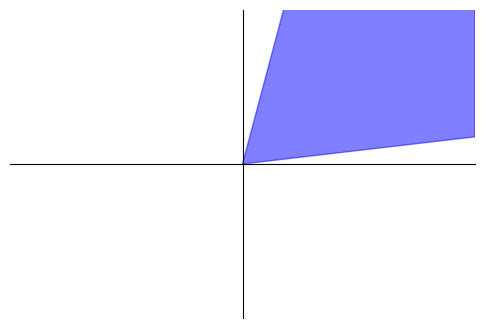

In [2]:
order = ConeTheta2DOrder(cone_degree=70)
fig_cone = order.ordering_cone.plot()

In [3]:
# Some algorithm parameters
epsilon = 0.01
delta = 0.05
noise_var = 1e-5

Define an instance of `BraninCurrin` problem and visualize a sample Pareto front.

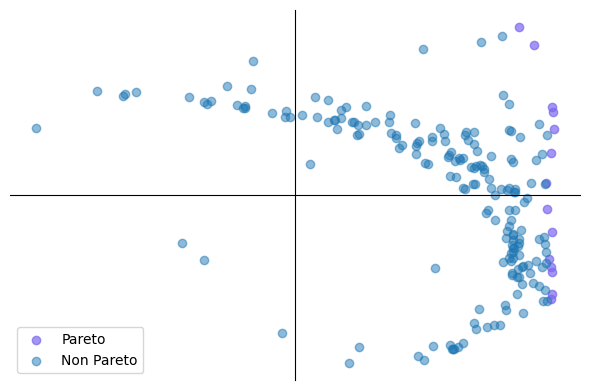

In [4]:
problem_name = "BraninCurrin"
problem = get_continuous_problem(problem_name, noise_var=noise_var)

sample_size = 200
sample_X = unnormalize(np.random.rand(sample_size, problem.in_dim), problem.bounds)
sample_Y = problem.evaluate(sample_X, noisy=False)

fig_pareto = order.plot_pareto_set(sample_Y)

Run the `VOGP_AD` algorithm until the end, it could take a couple of minutes.

In [5]:
algorithm = VOGP_AD(
    epsilon=epsilon,
    delta=delta,
    problem=problem,
    order=order,
    noise_var=noise_var,
    conf_contraction=32,
)

while True:
    is_done = algorithm.run_one_step()

    if is_done:
        break

We now visualize the adaptively discretized domain. Note that this depends on the `max_depth` attribute of the `problem`.

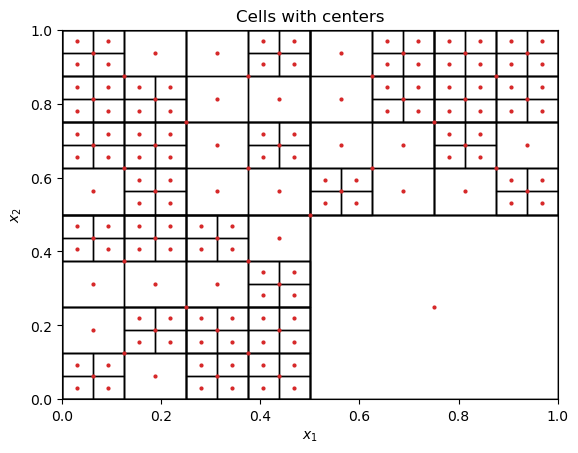

In [6]:
_ = algorithm.design_space.visualize_design_space()

Next, we calculate the log hypervolume (HV) discrepancy of the resulting models predictions.

In [7]:
log_hv_discrepancy = calculate_hypervolume_discrepancy_for_model(order, problem, algorithm.model)
print(log_hv_discrepancy)

-1.9115855984158816


Generate a random set of inputs and visualize the true Pareto front.

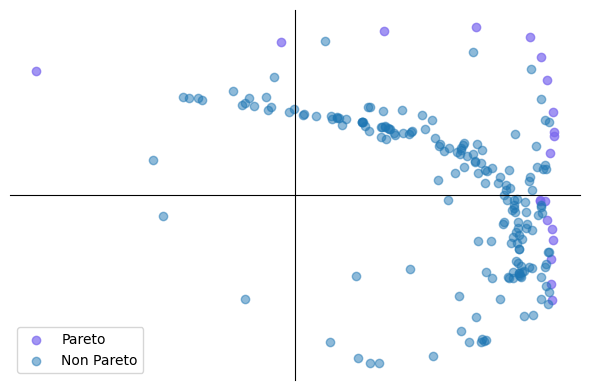

In [8]:
x = unnormalize(np.random.rand(sample_size, problem.in_dim), problem.bounds)

f = problem.evaluate(x, noisy=False)
y, _ = algorithm.model.predict(x)

fig_pareto = order.plot_pareto_set(f)

For the same random set of inputs, visualize the model predicted Pareto front.

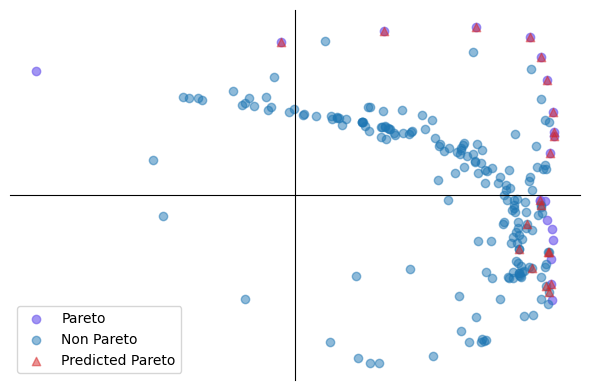

In [9]:
pred_pareto_indices = order.get_pareto_set(y)

tmp_pareto_fig = deepcopy(fig_pareto)
tmp_pareto_fig.axes[0].scatter(
    f[pred_pareto_indices][:, 0],
    f[pred_pareto_indices][:, 1],
    c="tab:red", label="Predicted Pareto", alpha=0.5, marker="^"
)
tmp_pareto_fig.axes[0].legend()
tmp_pareto_fig